In [1]:
import tarfile
import urllib
from pathlib import Path
import numpy as np
from numba.np.arraymath import check_array
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer

url_root = "https://spamassassin.apache.org/old/publiccorpus/"
ham_root = "20030228_easy_ham.tar.bz2"
spam_root = "20030228_spam.tar.bz2"
spam_folder_path = Path("data/spam")
ham_folder_path = Path("data/ham")
spam_folder_path.mkdir(parents=True, exist_ok=True)
ham_folder_path.mkdir(parents=True, exist_ok=True)
for tar_file_name,folder_name in [(ham_root, ham_folder_path),(spam_root, spam_folder_path)]:
    tarball_path = Path() / "data" / tar_file_name
    urllib.request.urlretrieve(url_root + tar_file_name,tarball_path)
    with tarfile.open(tarball_path) as tar:
        tar.extractall(path=folder_name,filter="fully_trusted")



In [155]:
ham_files_path = ham_folder_path / "easy_ham"
spam_files_path = spam_folder_path / "spam"
ham_files_names = [file_name for file_name in ham_files_path.iterdir() if len(file_name.name) > 20]
spam_files_names = [file_name for file_name in spam_files_path.iterdir() if len(file_name.name) > 20]
print(len(ham_files_names), len(spam_files_names))

2500 500


In [156]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score

ham_labels = ["ham" for _ in range(len(ham_files_names))]
spam_labels = ["spam" for _ in range(len(spam_files_names))]
y_data = ham_labels + spam_labels
y_data = np.array(y_data)
X_data = ham_files_names + spam_files_names
X_data = np.array(X_data)
data = pd.DataFrame({"file_name":X_data,"label":y_data})
train_split,test_split = train_test_split(data,test_size=0.25,stratify=data["label"],random_state=42)

In [157]:
print(train_split["label"].value_counts(normalize=True))
print(test_split["label"].value_counts(normalize=True))
  

label
ham     0.833333
spam    0.166667
Name: proportion, dtype: float64
label
ham     0.833333
spam    0.166667
Name: proportion, dtype: float64


In [158]:
import re
import chardet
import email
from email import policy
from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator,TransformerMixin

class MsgTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,element=None,url_repace=True,email_repace=True,numb_repace=True,lower=True,max_len=None,msg_as_string=True):
        self.url_repace = url_repace
        self.email_repace = email_repace
        self.numb_repace = numb_repace
        self.lower = lower
        self.max_len = max_len
        self.msg_as_string = msg_as_string
        self.element = element

    def __extract_body(self,X,element=None):
        with Path(X).open("rb") as email_file:
            em = email.message_from_bytes(email_file.read(), policy=policy.default)
            if element:
                return em[element]
            seen=[part.get_content_type() for part in em.walk()]
            for part in em.walk():
                seen.append(part.get_content_type())
                if part.get_content_type() == "text/plain":
                    return str(part.get_payload(decode=True))
                if part.get_content_type() == "text/html":
                    parsed_message = BeautifulSoup(part.get_payload(decode=True), "lxml")
                    return str(parsed_message.get_text())
                if "text/html" not in seen and "text/plain" not in seen:
                    parsed_message = BeautifulSoup(part.get_payload(decode=True), "lxml")
                    return str(parsed_message.get_text())

    def __clean_body(self,X,url_repace=True,email_repace=True,numb_repace=True,lower=True,max_len=None,msg_as_string=True):
        X = re.sub(r"\\n"," ",X)
        X = re.sub(r"\xa0"," ",X)
        X = re.sub(r"\n"," ",X)
        X = re.sub(r"\t"," ",X)
        if url_repace:
            X = re.sub(r"https?://\S+","url",X)
        if email_repace:
            X = re.sub(r"\S+@\S+","emaail",X)
        if numb_repace:
            X = re.sub(r"[0-9]+","nb",X)
        X = re.sub(r"[^\w\s]|_"," ",X)
        if lower:
            X = X.lower()
        X = X.split(" ")
        if max_len:
            X = [word for word in X if len(word) > 1 and len(word) <= max_len]
        else:
            X = [word for word in X if len(word) > 1]
        if msg_as_string:
            return " ".join(X)
        else:
            return str(X)

    def fit(self,X,y=None):
        return self

    def __extract_clean(self,X):
        msg = self.__extract_body(X,element=self.element)
        return self.__clean_body(msg,
                               url_repace=self.url_repace,
                               email_repace=self.email_repace,
                               numb_repace=self.numb_repace,
                               lower=self.lower,
                               max_len=self.max_len,
                               msg_as_string=self.msg_as_string)



    def transform(self, X, y=None):
        X = np.array(X)
        vfunc = np.vectorize(self.__extract_clean,otypes=[str])
        return vfunc(X)

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
class MsgToMatrixTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,element=None,url_repace=True,email_repace=True,numb_repace=True,lower=True,max_len=None):
        self.url_repace = url_repace
        self.email_repace = email_repace
        self.numb_repace = numb_repace
        self.lower = lower
        self.max_len = max_len
        self.element = element

    def fit(self,X,y=None):
        X = X.flatten()
        self.vectorizer = CountVectorizer(lowercase=False)
        self.vectorizer.fit(X)
        return self

    def transform(self,X,y=None):
        X = X.flatten()
        X = self.vectorizer.transform(X)
        return X.toarray()

    def get_feature_names_out(self,names=None):
        return self.vectorizer.get_feature_names_out()



In [160]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

msg_to_str = MsgTransformer()
msg_to_matrix= MsgToMatrixTransformer()
pipeline_msg = Pipeline([
    ("msg",msg_to_str),
    ("msg_matrix",msg_to_matrix)
])

sub_to_str = MsgTransformer(element="Subject")
sub_to_matrix= MsgToMatrixTransformer()
pipeline_sub = Pipeline([
    ("sub", sub_to_str),
    ("sub_matrix",sub_to_matrix)
])

msg_to_list = MsgTransformer(msg_as_string=False)
pipeline_len = Pipeline([
    ("msg_list",msg_to_list),
    ("len",FunctionTransformer(lambda x: np.array([[len(i)] for i in x])),)
])

preprocesing = ColumnTransformer([
    ("cl_msg",pipeline_msg,["file_name"]),
    ("cl_sub",pipeline_sub,["file_name"]),
    ("len",pipeline_len,["file_name"]),

],
remainder="drop")

In [161]:

msg_to_list = MsgTransformer(msg_as_string=False)
train_data = msg_to_list.fit_transform(train_split["file_name"])
train_data = pd.DataFrame({"msg":train_data})
train_data["label"] = train_split["label"].to_numpy()
train_data.head()

,msg,label
0,"['url', 'url', 'date', 'not', 'supplied', 'img...",ham
1,"['kenya', 'do', 'you', 'have', 'too', 'much', ...",spam
2,"['we', 'met', 'family', 'in', 'our', 'parent',...",ham
3,"['url', 'url', 'date', 'nb', 'nb', 'nbtnb', 'n...",ham
4,"['url', 'url', 'date', 'nb', 'nb', 'nbtnb', 'n...",ham


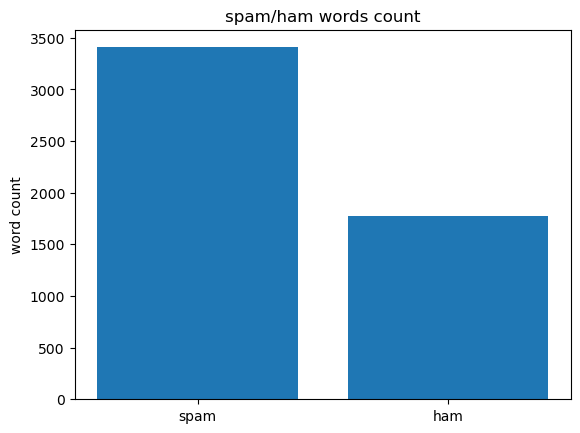

In [162]:
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
train_data["msg_len"] = train_data["msg"].apply(len)
spam_msg = train_data["msg_len"][train_data["label"] == "spam"]
ham_msg = train_data["msg_len"][train_data["label"] == "ham"]
spam_mean_len = spam_msg.mean()
ham_mean_len = ham_msg.mean()

fig ,ax = plt.subplots()
ax.bar(["spam","ham"],[spam_mean_len,ham_mean_len])
plt.title("spam/ham words count")
plt.ylabel("word count")
plt.show()

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
rnd_cl = Pipeline([
    ("preprocesing",preprocesing),
    ("rand_fs",RandomForestClassifier(random_state=42,n_jobs=-1)),
])
sgd_clf = Pipeline([
    ("preprocesing",preprocesing),
    ("sgd",SGDClassifier(random_state=42,n_jobs=-1)),
])
svc_clf = Pipeline([
    ("preprocesing",preprocesing),
    ("svc",SGDClassifier(random_state=42,n_jobs=-1)),
])
knn_clf = Pipeline([
    ("preprocesing",preprocesing),
    ("knn",KNeighborsClassifier()),
])

models = {
    "random_forest": rnd_cl,
    "sgd": sgd_clf,
    "svc": svc_clf,
    "knn": knn_clf,
}

X_train = train_split.drop("label",axis=1)
y_train = train_split["label"].copy()


In [164]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

def test(model):
    for model in models.keys():
        y_pred = cross_val_predict(models[model],X_train,y_train,cv=3,n_jobs=-1)
        y_pred = (y_pred == "ham")
        y_t = (y_train == "ham")
        ConfusionMatrixDisplay.from_predictions(y_t,y_pred)
        plt.show()
        print(f"{model} accuracy_score: {accuracy_score(y_t, y_pred)}")
        print(f"{model} recall_score: {recall_score(y_t, y_pred)}")
        print(f"{model} f1_score: {f1_score(y_t,y_pred)}")
        print("---------------------------------------------------")

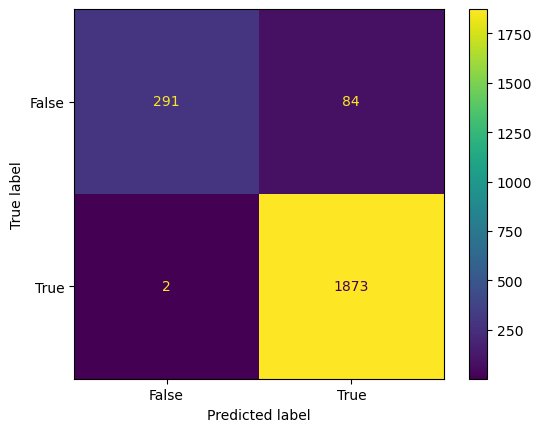

random_forest accuracy_score: 0.9617777777777777
random_forest recall_score: 0.9989333333333333
random_forest f1_score: 0.9775574112734864
---------------------------------------------------


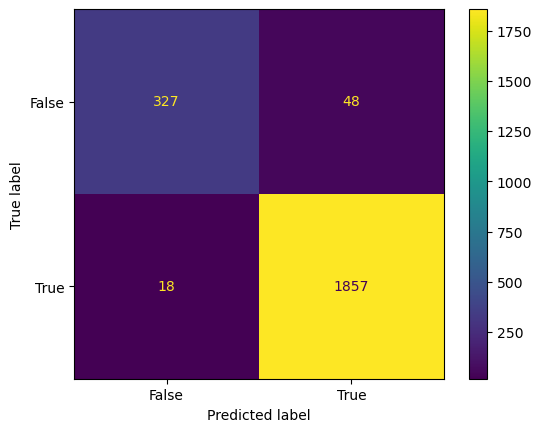

sgd accuracy_score: 0.9706666666666667
sgd recall_score: 0.9904
sgd f1_score: 0.9825396825396825
---------------------------------------------------


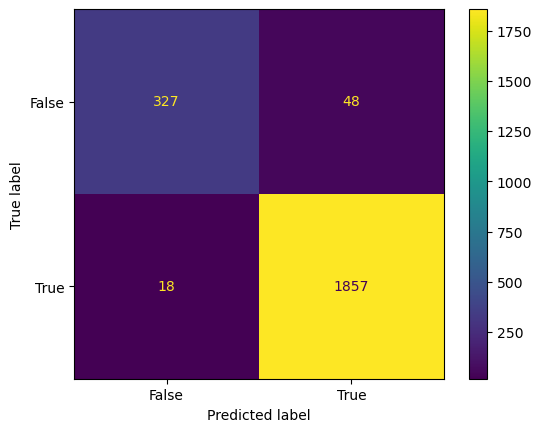

svc accuracy_score: 0.9706666666666667
svc recall_score: 0.9904
svc f1_score: 0.9825396825396825
---------------------------------------------------


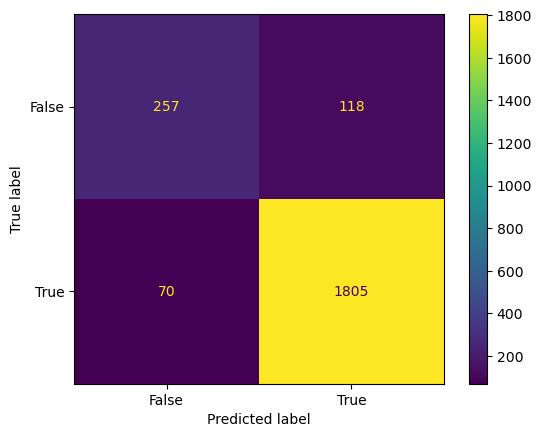

knn accuracy_score: 0.9164444444444444
knn recall_score: 0.9626666666666667
knn f1_score: 0.9505002632964719
---------------------------------------------------


In [165]:
test(models)

In [166]:
from sklearn.model_selection import GridSearchCV
X_test = test_split.drop("label",axis=1)
y_test = test_split["label"].copy()
param_distrib = {
     "preprocesing__cl_msg__msg__max_len":[None,10],
     "preprocesing__cl_sub__sub__max_len":[None,10],
     "sgd__alpha":[0.0001,0.001]
}
grid_search = GridSearchCV(sgd_clf,param_distrib,cv=3,n_jobs=-1,verbose=3)
grid_search.fit(X_train,y_train)
final_model = grid_search.best_estimator_
final_model.fit(X_train,y_train)
final_model.score(X_test,y_test)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


0.972

In [167]:
grid_search.best_params_

{'preprocesing__cl_msg__msg__max_len': 10,
 'preprocesing__cl_sub__sub__max_len': 10,
 'sgd__alpha': 0.0001}

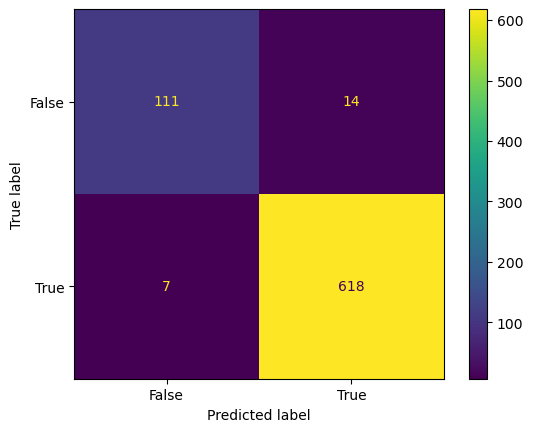

accuracy_score: 0.972
recall_score: 0.9888
f1_score: 0.9832935560859188
roc_auc_score: 0.9384


In [168]:
from sklearn.metrics import roc_auc_score
y_pred = final_model.predict(X_test)
y_pred = (y_pred == "ham")
y_t = (y_test == "ham")
ConfusionMatrixDisplay.from_predictions(y_t,y_pred)
plt.show()
print(f"accuracy_score: {accuracy_score(y_t, y_pred)}")
print(f"recall_score: {recall_score(y_t, y_pred)}")
print(f"f1_score: {f1_score(y_t, y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_t, y_pred)}")